In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## 1. Synthetic data setup 


### 1.1. Linear Model

1. We have a true (unknown in real scenarios) data-generating process:

   $$ y = w_0 + w_1 X + \epsilon $$

   where $ \epsilon \sim \mathcal{N}(0, \sigma^2) $.

2. In the code, we pick:
   - $ w_0 = 2 $
   - $ w_1 = 0.5 $
   - Noise $ \epsilon \sim \mathcal{N}(0, 0.2^2) $.

3. We generate $ X $ values evenly spaced from 0 to 10, and then sample $ y $ by adding a small random Gaussian noise to $ w_0 + w_1 X $.

This results in 20 data points $ (X_i, y_i) $.


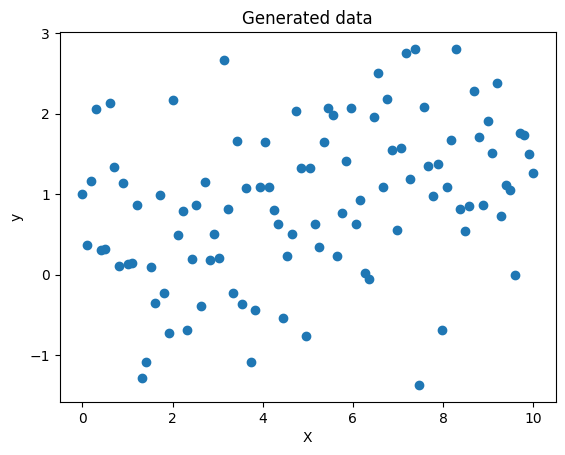

In [82]:
np.random.seed(42)
X = np.linspace(0, 10, 100)

# true weights 
true_w0, true_1 = 0.5,0.1

# generate X values evenly spaced between 0 and 100 and sample y by adding a small amount of Gaussian noise
# to w_0 + w_1 * X
# the result is 100 datapoints (X_i, y_i) where y_i = w_0 + w_1 * X_i + epsilon_i

y = true_w0 + true_1 * X + np.random.normal(0, 1, X.shape)

# plot the data 

plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Generated data')
plt.show()

## Prior distribution 

### 2.1. Bayesian Framework

1. **Parameters**: We define our parameter vector **w** as:

   $$
   \mathbf{w} =
   \begin{bmatrix}
   w_0 \\
   w_1
   \end{bmatrix}.
   $$

2. **Prior Distribution**: We place a Gaussian (normal) prior on **w**:

   $$
   p(\mathbf{w}) = \mathcal{N}(\boldsymbol{\mu}_{\text{prior}}, \mathbf{\Sigma}_{\text{prior}}).
   $$

   In code:
   - `prior_mean = [0, 0]` implies $\boldsymbol{\mu}_{\text{prior}} = (0,0)$.
   - `prior_cov = [[1, 0], [0, 1]]` implies $\mathbf{\Sigma}_{\text{prior}}$ is the $2 \times 2$ identity matrix $\mathbf{I}$.

3. **Intuition**: Saying that $w_0$ and $w_1$ both have prior means of 0 and are uncorrelated with each other, with variance 1, means *a priori* we believe both parameters likely lie near 0, but they could deviate from 0 with standard deviation 1.



In [83]:
# priot mean 
prior_mean = np.array([0, 0])
prior_cov = np.array([[1, 0], [0, 1]])

## Posterior distribution 

# 3.1. Likelihood

The **likelihood** of the observed data $\{(x_i, y_i)\}_{i=1}^{N}$ given parameters **w** is assumed to be:

$$
p(\mathbf{y} \mid \mathbf{w}) = \prod_{i=1}^{N} \mathcal{N}(y_i \mid w_0 + w_1 x_i, \sigma^2),
$$

where $\sigma^2$ is the noise variance (`noise_var` in the code). This leads to a matrix form:

$$
\mathbf{y} \sim \mathcal{N}(\mathbf{X} \mathbf{w}, \sigma^2 \mathbf{I}),
$$

where

$$
\mathbf{X} =
\begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_N
\end{bmatrix}, \quad
\mathbf{w} =
\begin{bmatrix}
w_0 \\
w_1
\end{bmatrix}.
$$

# 3.2. Posterior Derivation

Given a Gaussian prior and a Gaussian likelihood, the posterior over **w** is also Gaussian, with:

$$
\mathbf{\Sigma}_{\text{post}} = \left(\mathbf{\Sigma}_{\text{prior}}^{-1} + \frac{1}{\sigma^2} \mathbf{X}^T \mathbf{X} \right)^{-1},
$$

$$
\boldsymbol{\mu}_{\text{post}} = \mathbf{\Sigma}_{\text{post}} \left( \mathbf{\Sigma}_{\text{prior}}^{-1} \boldsymbol{\mu}_{\text{prior}} + \frac{1}{\sigma^2} \mathbf{X}^T \mathbf{y} \right).
$$

In the code:

- `X_design = np.column_stack([np.ones_like(X), X])` creates the matrix $\mathbf{X}$ by stacking a column of 1s (for the intercept $w_0$) and the column of $X$ values.

- `posterior_cov = np.linalg.inv(np.linalg.inv(prior_cov) + (1/noise_var) * X_design.T @ X_design)` implements:

  $$
  \mathbf{\Sigma}_{\text{post}} = \left(\mathbf{\Sigma}_{\text{prior}}^{-1} + \frac{1}{\sigma^2} \mathbf{X}^T \mathbf{X} \right)^{-1}.
  $$

- `posterior_mean = posterior_cov @ (np.linalg.inv(prior_cov) @ prior_mean + (1/noise_var) * X_design.T @ y)` implements:

  $$
  \boldsymbol{\mu}_{\text{post}} = \mathbf{\Sigma}_{\text{post}} \left( \mathbf{\Sigma}_{\text{prior}}^{-1} \boldsymbol{\mu}_{\text{prior}} + \frac{1}{\sigma^2} \mathbf{X}^T \mathbf{y} \right).
  $$

Thus, after running `post_mean, post_cov = compute_posterior(...)`, we get the posterior’s mean vector $\boldsymbol{\mu}_{\text{post}} \in \mathbb{R}^2$ and covariance matrix $\mathbf{\Sigma}_{\text{post}} \in \mathbb{R}^{2 \times 2}$.



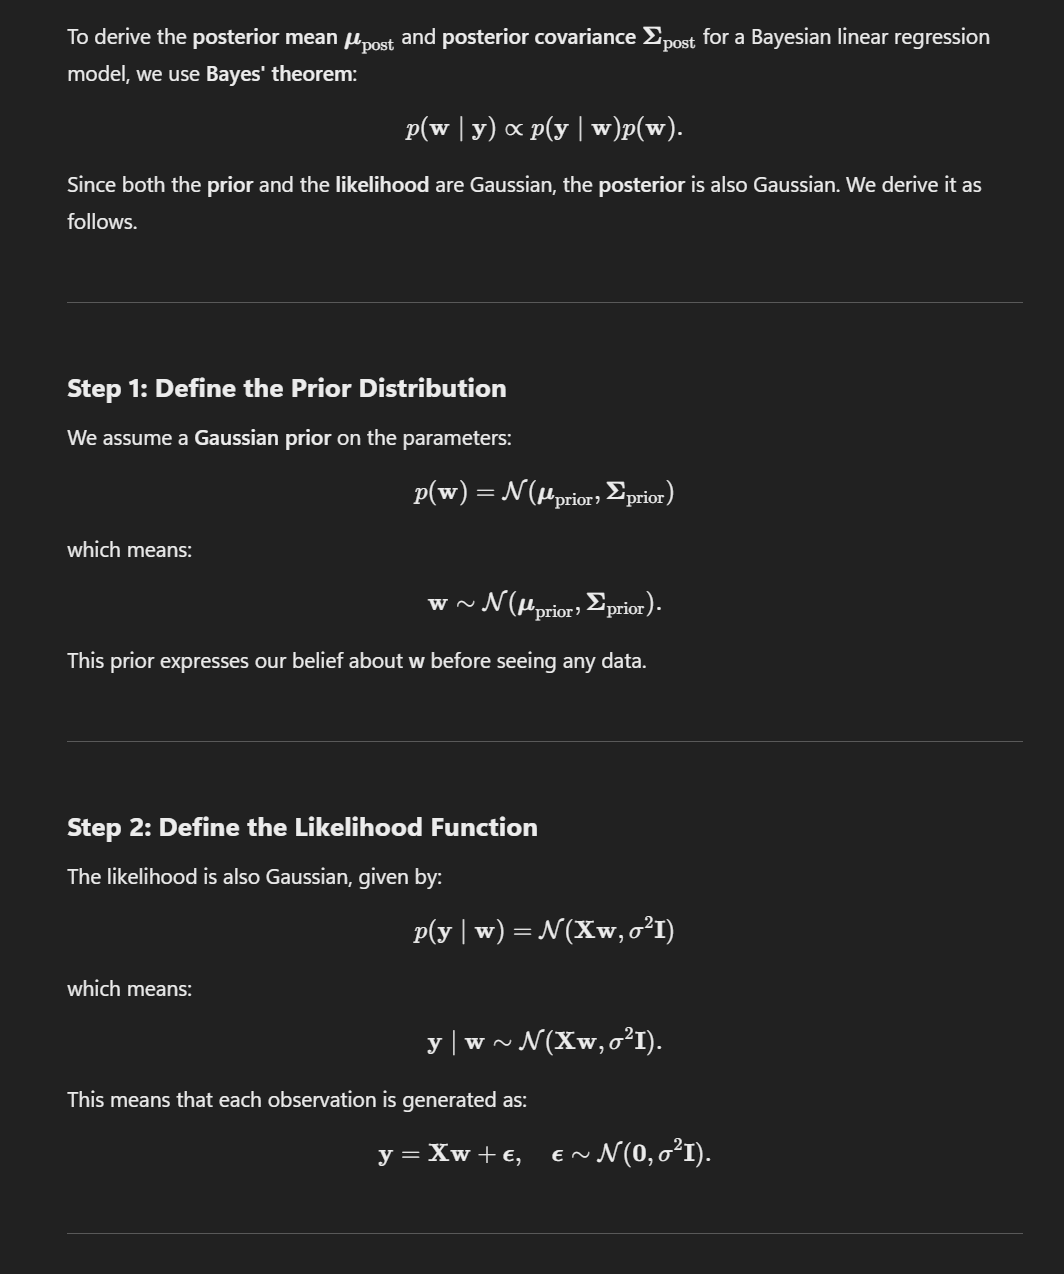

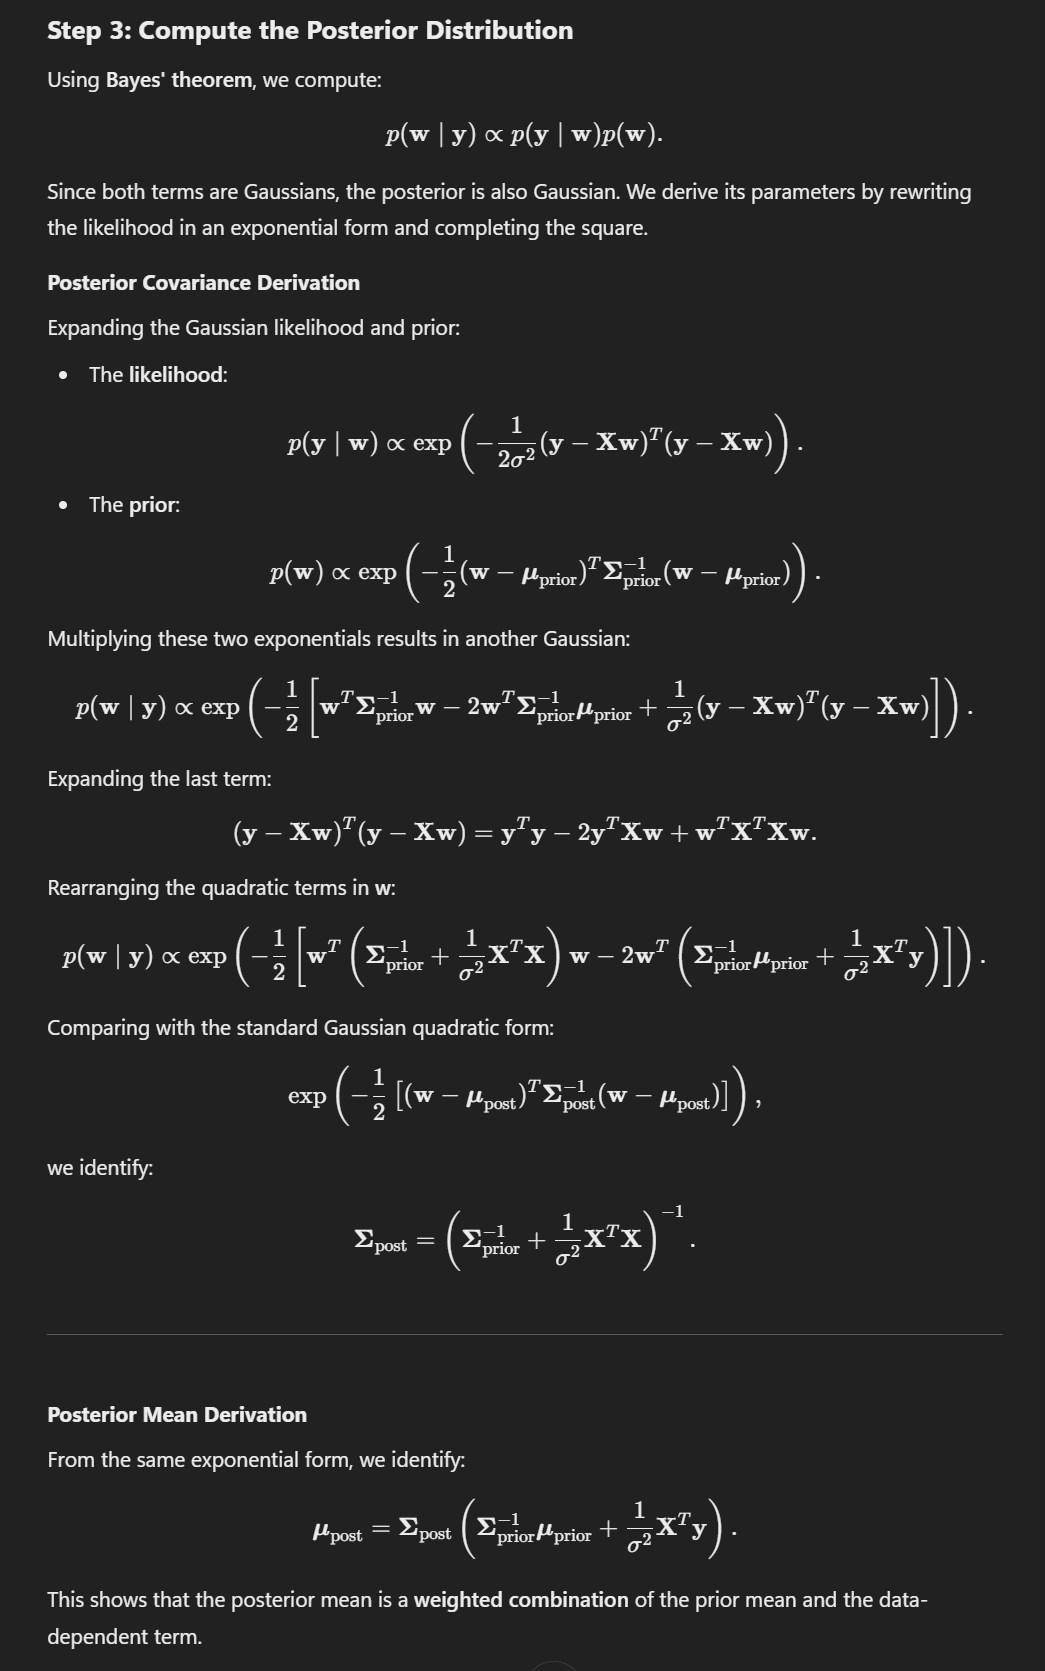

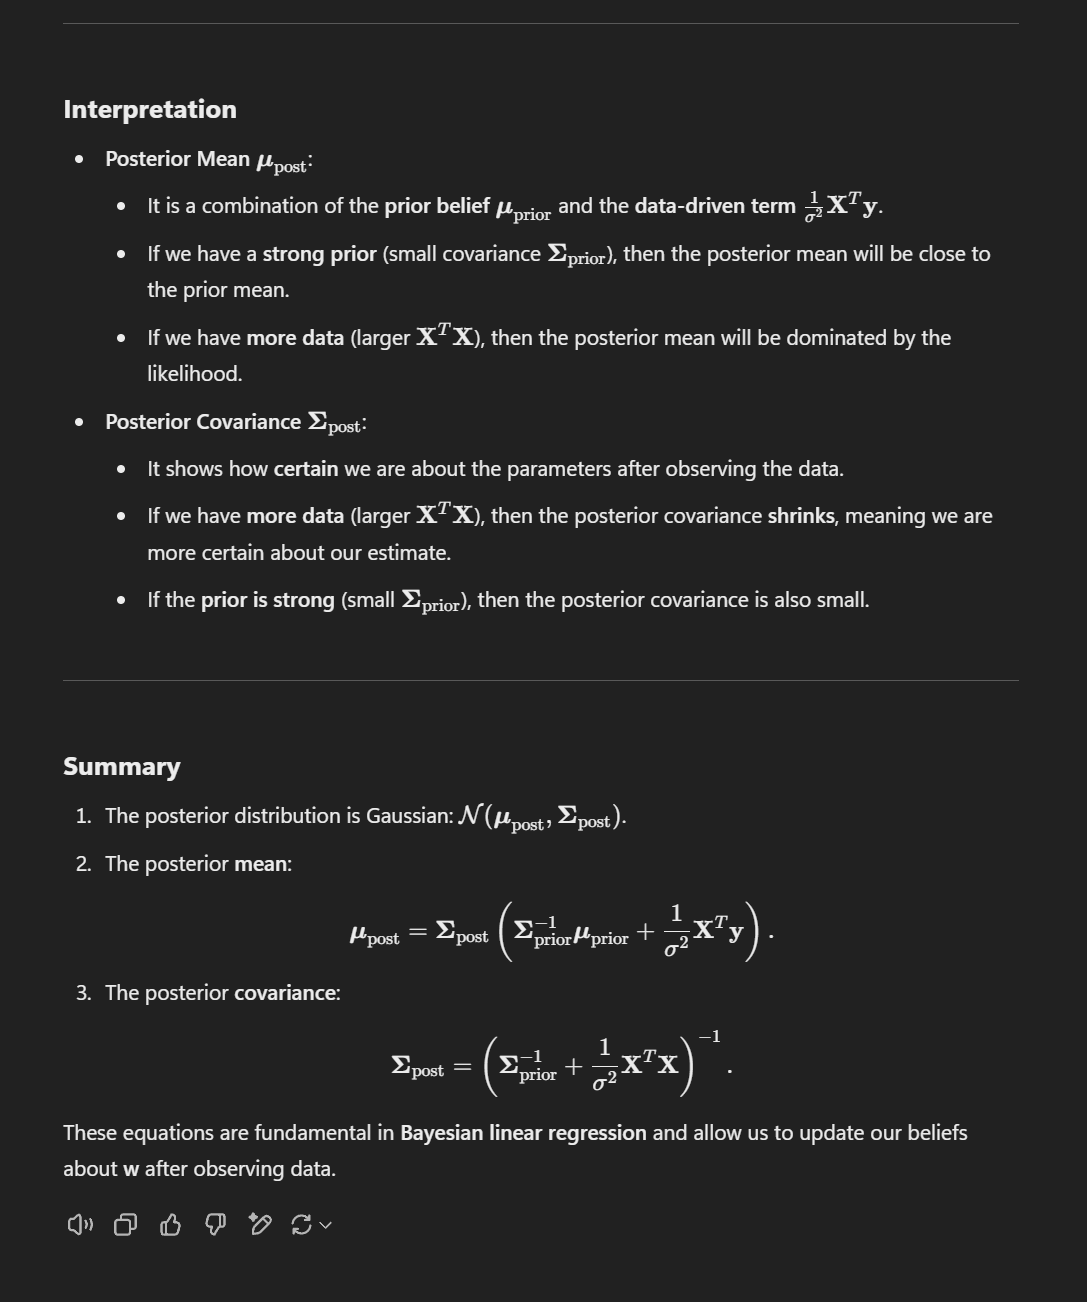

In [84]:
def compute_posterior(X, y, prior_mean, prior_cov, noise_var=0.2**2):
    # Create design matrix X by adding a column of ones for the intercept term
    # Shape: (n_samples, 2) where 2 represents [intercept, X]
    X_design = np.column_stack([np.ones_like(X), X])
    
    # Compute posterior covariance matrix using the formula:
    # Σ_post = (Σ_prior^(-1) + (1/σ²)X^T X)^(-1)
    # where σ² is the noise variance
    posterior_cov = np.linalg.inv(
        np.linalg.inv(prior_cov) + 
        (1/noise_var) * X_design.T @ X_design
    )
    
    # Compute posterior mean using the formula:
    # μ_post = Σ_post(Σ_prior^(-1)μ_prior + (1/σ²)X^T y)
    # This combines prior information with the observed data
    posterior_mean = posterior_cov @ (
        np.linalg.inv(prior_cov) @ prior_mean + 
        (1/noise_var) * X_design.T @ y
    )
    
    # Return both the posterior mean (weights) and covariance matrix
    # posterior_mean shape: (2,) - [w0, w1]
    # posterior_cov shape: (2, 2) - covariance matrix for w0 and w1
    return posterior_mean, posterior_cov


Design matrix: [[ 1.          0.        ]
 [ 1.          0.1010101 ]
 [ 1.          0.2020202 ]
 [ 1.          0.3030303 ]
 [ 1.          0.4040404 ]
 [ 1.          0.50505051]
 [ 1.          0.60606061]
 [ 1.          0.70707071]
 [ 1.          0.80808081]
 [ 1.          0.90909091]
 [ 1.          1.01010101]
 [ 1.          1.11111111]
 [ 1.          1.21212121]
 [ 1.          1.31313131]
 [ 1.          1.41414141]
 [ 1.          1.51515152]
 [ 1.          1.61616162]
 [ 1.          1.71717172]
 [ 1.          1.81818182]
 [ 1.          1.91919192]
 [ 1.          2.02020202]
 [ 1.          2.12121212]
 [ 1.          2.22222222]
 [ 1.          2.32323232]
 [ 1.          2.42424242]
 [ 1.          2.52525253]
 [ 1.          2.62626263]
 [ 1.          2.72727273]
 [ 1.          2.82828283]
 [ 1.          2.92929293]
 [ 1.          3.03030303]
 [ 1.          3.13131313]
 [ 1.          3.23232323]
 [ 1.          3.33333333]
 [ 1.          3.43434343]
 [ 1.          3.53535354]
 [ 1.        

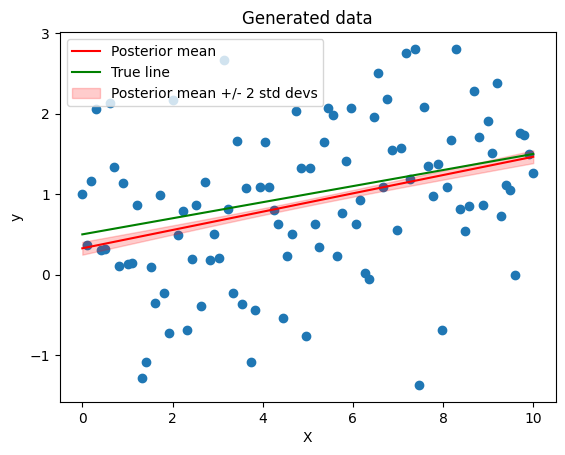

In [85]:
posterior_mean, posterior_cov = compute_posterior(X, y, prior_mean, prior_cov)

# plot the data and the posterior mean
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Generated data')
plt.plot(X, posterior_mean[0] + posterior_mean[1] * X, color='red', label='Posterior mean')
plt.plot(X, true_w0 + true_1 * X, color='green', label='True line')

# show the variances
X_design = np.column_stack([np.ones_like(X), X])
# print the design matrix 
print(f"Design matrix: {X_design}")
# shape of design matrix
print(f"Design matrix shape: {X_design.shape}")
std_devs = np.sqrt(np.sum((X_design @ posterior_cov) * X_design, axis=1))
plt.fill_between(X, posterior_mean[0] + posterior_mean[1] * X - 2 * std_devs, posterior_mean[0] + posterior_mean[1] * X + 2 * std_devs, color='red', alpha=0.2, label='Posterior mean +/- 2 std devs')

plt.legend()
plt.show()



## 4. Making predictions 

### 4.1. Why Sample?

In Bayesian regression, after observing data, our belief about the parameters **w** is described by the posterior distribution $\mathcal{N}(\boldsymbol{\mu}_{\text{post}}, \mathbf{\Sigma}_{\text{post}})$. The **predictive distribution** for a new input $x_{\text{new}}$ is:

$$
p(y_{\text{new}} \mid x_{\text{new}}, \mathbf{X}, \mathbf{y}) = \int p(y_{\text{new}} \mid x_{\text{new}}, \mathbf{w}) p(\mathbf{w} \mid \mathbf{X}, \mathbf{y}) \, d\mathbf{w}.
$$

- Since both $p(\mathbf{w} \mid \mathbf{X}, \mathbf{y})$ and $p(y_{\text{new}} \mid x_{\text{new}}, \mathbf{w})$ are **Gaussian**, one can analytically derive the predictive mean and variance.
  
- Alternatively, we can **sample** from the posterior **w** (which is easy to do, as it is a multivariate normal) and then for each sample $\mathbf{w}^{(s)}$, compute:

  $$
  y_{\text{new}}^{(s)} = w_0^{(s)} + w_1^{(s)} x_{\text{new}}.
  $$

  Averaging these gives an empirical estimate of the predictive distribution.


### 4.2. The steps in the code 

1. Draw samples (w_sample= np.random.multivariate_normal(...)) from the posterior distribution of w. We get `n_samples` samples drawn from 2D Gaussian. 

2. Compute predicted outputs for each sample: `y_pred = x_0 + w_1 x_new`. This gives `n_samples` predictions for each input in `x_new`.

3. Agregate predictions: 
    - np.mean(predictions, axis = 0) gives the mean of all predictions across the posterior samples i.e. an approximation of $\mathbb{E}[y_{\text{new} | x_{new}, X, y}]$
    - np.percentile gives the 95% confidence interval of the predictions across the posterior samples.

In [88]:
def predict(x_new, post_mean, post_cov, n_samples=1000):
    """
    Make predictions using Bayesian linear regression.
    
    Parameters:
    -----------
    x_new : array-like
        New input points for prediction
    post_mean : array-like
        Posterior mean parameters [w0, w1]
    post_cov : array-like
        Posterior covariance matrix (2x2)
    n_samples : int
        Number of samples to draw from posterior distribution
    
    Returns:
    --------
    mean_pred : array-like
        Mean predictions for each input point
    conf_intervals : array-like
        95% confidence intervals for predictions, shape (2, len(x_new))
    """
    # Sample from posterior distribution - shape: (n_samples, 2)
    w_samples = np.random.multivariate_normal(post_mean, post_cov, n_samples)
    
    # Create design matrix for new points - shape: (len(x_new), 2)
    X_new = np.column_stack([np.ones_like(x_new), x_new])
    
    # Vectorized prediction computation
    # Matrix multiplication: (n_samples, 2) @ (2, len(x_new)) -> (n_samples, len(x_new))
    predictions = w_samples @ X_new.T
    
    # Calculate mean prediction and confidence intervals
    mean_pred = np.mean(predictions, axis=0)
    conf_intervals = np.percentile(predictions, [2.5, 97.5], axis=0)
    
    return mean_pred, conf_intervals, predictions


In [93]:
X_new = np.linspace(0, 50, 100)
y_mean, (y_lower, y_upper), predictions = predict(X_new, posterior_mean, posterior_cov)


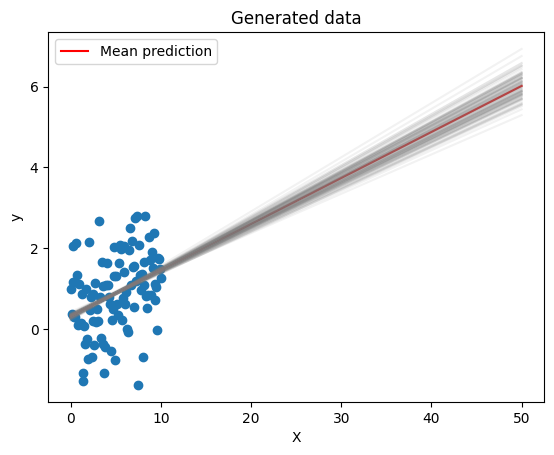

In [100]:
# plot all the predictions 

plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Generated data')
plt.plot(X_new, y_mean, color='red', label='Mean prediction')
#plt.fill_between(X_new, y_lower, y_upper, color='red', alpha=0.2, label='95% confidence interval')
# Plot a subset of samples for better visualization (e.g., 100 samples)
plt.plot(X_new, predictions[:100, :].T, color='gray', alpha=0.1)  # Plot all 100 samples at once using matrix transpose
plt.legend()
plt.show()


In [101]:
# https://chatgpt.com/share/679df2e8-d700-800e-b364-6300610def62